In [ ]:
!pip3 install keras-tuner

In [ ]:
DATASET_PATH = "Metro_Interstate_Traffic_Volume.csv"
LABEL_NAME = "traffic_volume"

# "r" for regression and "c" for classification
# for classification, the number of output nodes is automatically determined
TASK = "r"

# don't change the dummy batch size. There is a small bug in tensorflow.
# to get around that bug, dummy batch size is used
DUMMY_BATCH_SIZE = 5
BATCH_SIZE = 100
EPOCHS = 100
TRAIN_FRAC = 0.8

CHECKPOINT_DIR = "./metro_models/"

In [ ]:
from collections import defaultdict
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import kerastuner as kt

import IPython

# This function will give us a fresh dataset object

In [ ]:
def get_dataset(batch_size = 5):
    return tf.data.experimental.make_csv_dataset(
        DATASET_PATH,
        batch_size = batch_size,
        label_name = LABEL_NAME,
        num_epochs = 1
    )

# If classification, Find Number of labels (for output nodes)

In [ ]:
if TASK == "r":
    OUTPUT_NODES = 1

elif TASK == "c":
    unique_labels = set()

    for _, label in get_dataset(batch_size=BATCH_SIZE):
        for ele in label.numpy():
            unique_labels.add(ele)

    num_labels = len(unique_labels)

    if num_labels <= 2:
        OUTPUT_NODES = 1
    else:
        OUTPUT_NODES = num_labels
    
    print(unique_labels)

print("output nodes: ", OUTPUT_NODES)

output nodes:  1


# Creating the Model Inputs as a dictionary

In [ ]:
model_inputs = {}

for batch, _ in get_dataset(batch_size=DUMMY_BATCH_SIZE).take(1):
    for col_name, col_values in batch.items():
        model_inputs[col_name] = tf.keras.Input(shape=(1,), name=col_name, dtype=col_values.dtype)

In [ ]:
model_inputs

{'clouds_all': <tf.Tensor 'clouds_all:0' shape=(None, 1) dtype=int32>,
 'holiday': <tf.Tensor 'holiday:0' shape=(None, 1) dtype=string>,
 'rain_1h': <tf.Tensor 'rain_1h:0' shape=(None, 1) dtype=float32>,
 'snow_1h': <tf.Tensor 'snow_1h:0' shape=(None, 1) dtype=float32>,
 'temp': <tf.Tensor 'temp:0' shape=(None, 1) dtype=float32>,
 'weather_description': <tf.Tensor 'weather_description:0' shape=(None, 1) dtype=string>,
 'weather_main': <tf.Tensor 'weather_main:0' shape=(None, 1) dtype=string>}

## split these inputs into their own dictionaries based on the data type

In [ ]:
integer_inputs = {}
float_inputs = {}
string_inputs = {}

for col_name, col_input in model_inputs.items():
    
    if col_input.dtype == tf.int32:
        integer_inputs[col_name] = col_input
    
    elif col_input.dtype == tf.float32:
        float_inputs[col_name] = col_input
    
    elif col_input.dtype == tf.string:
        string_inputs[col_name] = col_input

In [ ]:
int_inputs = {}
str_inputs = {}
float_inputs = {}

for col_name, col_input in model_inputs.items():

    if col_input.dtype == tf.int32:
        int_inputs[col_name] = col_input
    elif col_input.dtype == tf.float32:
        float_inputs[col_name] = col_input
    elif col_input.dtype == tf.string:
        str_inputs[col_name] = col_input

In [ ]:
integer_inputs

{'clouds_all': <tf.Tensor 'clouds_all:0' shape=(None, 1) dtype=int32>}

In [ ]:
float_inputs

{'rain_1h': <tf.Tensor 'rain_1h:0' shape=(None, 1) dtype=float32>,
 'snow_1h': <tf.Tensor 'snow_1h:0' shape=(None, 1) dtype=float32>,
 'temp': <tf.Tensor 'temp:0' shape=(None, 1) dtype=float32>}

In [ ]:
string_inputs

{'holiday': <tf.Tensor 'holiday:0' shape=(None, 1) dtype=string>,
 'weather_description': <tf.Tensor 'weather_description:0' shape=(None, 1) dtype=string>,
 'weather_main': <tf.Tensor 'weather_main:0' shape=(None, 1) dtype=string>}

In [ ]:
def numerical_input_processor(inputs):
    if not inputs:
        return
    
    concat = None
    if len(inputs.values()) > 1:
        concat = tf.keras.layers.Concatenate()(list(inputs.values()))
    
    norm = tf.keras.layers.experimental.preprocessing.Normalization()

    for batch, _ in get_dataset(batch_size=DUMMY_BATCH_SIZE).take(1):
        data = []
        
        for k in inputs.keys():
            data.append(np.array(batch[k]))    
        
        data = np.array(data)
        data = np.transpose(data)    

        norm.adapt(data)

    # mean_log = []

    for batch, _ in get_dataset(batch_size=BATCH_SIZE):
        data = []
        
        for k in inputs.keys():
            data.append(np.array(batch[k]))    
        
        data = np.array(data)
        data = np.transpose(data)

        norm.adapt(data, reset_state=False)        
        # mean_log.append(norm.mean.numpy())    

    if concat is not None:
        numeric_layer = norm(concat)
    else:
        numeric_layer = norm(list(inputs.values())[0])
    
    return numeric_layer

In [ ]:
def string_input_processor(inputs):
    if not inputs:
        return

    vocabularies = defaultdict(set)

    for batch, _ in get_dataset(batch_size=BATCH_SIZE):
        for col_name in inputs.keys():        
            for st in np.array(batch[col_name]).astype("str"):
                vocabularies[col_name].add(st.lower().strip())
    
    processed_string_inputs = []

    for col_name, col_input in inputs.items():    
        lookup = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=list(vocabularies[col_name]))
        one_hot = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = lookup.vocab_size())
        
        x = tf.strings.lower(col_input)
        x = tf.strings.strip(x)
        x = lookup(x)
        x = one_hot(x)
        
        processed_string_inputs.append(x)
    
    if len(processed_string_inputs) > 1:
        concat = tf.keras.layers.Concatenate()(processed_string_inputs)
        return concat    
    else:
        return processed_string_inputs[0]    

## PreProcess the inputs

In [ ]:
integer_layer = numerical_input_processor(integer_inputs)

In [ ]:
integer_layer

<tf.Tensor 'normalization/truediv:0' shape=(None, 1) dtype=float32>

In [ ]:
float_layer = numerical_input_processor(float_inputs)

In [ ]:
float_layer

<tf.Tensor 'normalization_1/truediv:0' shape=(None, 3) dtype=float32>

In [ ]:
string_layer = string_input_processor(string_inputs)

In [ ]:
string_layer

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 66) dtype=float32>

## add all the input layers to a list

In [ ]:
preprocessed_inputs = []

if integer_layer is not None:
    preprocessed_inputs.append(integer_layer)
if float_layer is not None:
    preprocessed_inputs.append(float_layer)
if string_layer is not None:
    preprocessed_inputs.append(string_layer)

In [ ]:
preprocessed_inputs

[<tf.Tensor 'normalization/truediv:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'normalization_1/truediv:0' shape=(None, 3) dtype=float32>,
 <tf.Tensor 'concatenate_1/concat:0' shape=(None, 66) dtype=float32>]

## Concatenate all the inputs

In [ ]:
if len(preprocessed_inputs) > 1:
    preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)
else:
    preprocessed_inputs_cat = preprocessed_inputs

## Create a preprocessing keras model

In [ ]:
preprocessing_head = tf.keras.Model(model_inputs, preprocessed_inputs_cat)

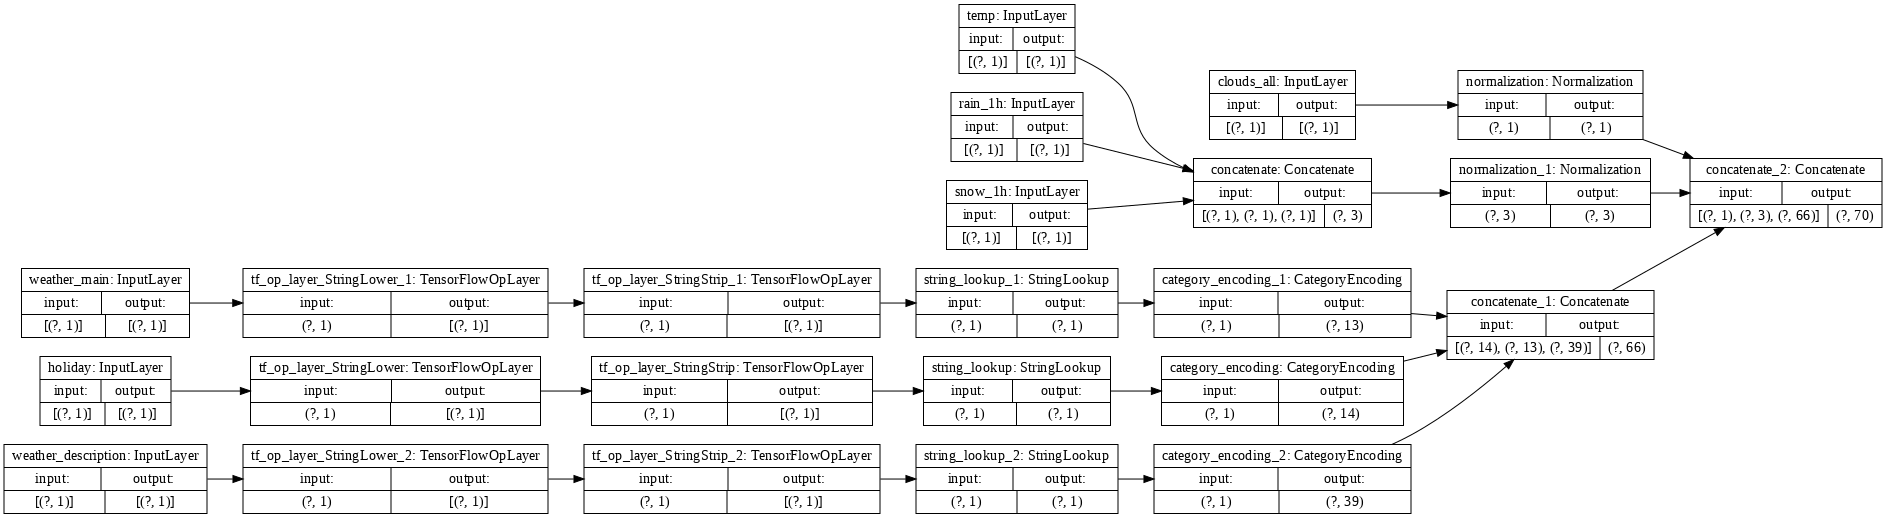

In [ ]:
tf.keras.utils.plot_model(model = preprocessing_head, rankdir="LR", dpi=72, show_shapes=True, expand_nested=True, to_file="preprocessing_head.png")

## You can also see the preprocessed outputs for the given inputs

In [ ]:
# preprocessing_head({
#     "sex" : np.array(["male"]),
#     "age" : np.array([22.0]),
#     "n_siblings_spouses" : np.array([1]),
#     "parch" : np.array([0]),
#     "fare" : np.array([7.25]),
#     "class" : np.array(["Third"]),
#     "deck" : np.array(["unknown"]),
#     "embark_town" : np.array(["Southampton"]),
#     "alone" : np.array(["n"]),
# })

# preprocessing_head({
#     "age" : np.array([22.0]),
#     "fare" : np.array([7.25]),
# })

## pass the model_inputs through the preprocessing_head

In [ ]:
preprocessed_outputs = preprocessing_head(model_inputs)

In [ ]:
num_preprocessed_outputs = list(preprocessed_outputs.shape)[-1]

In [ ]:
num_preprocessed_outputs

70

## Find out how many batches should be used for training and how many for validation

In [ ]:
dataset_size = 0

for _ in get_dataset(batch_size=BATCH_SIZE):
    dataset_size += 1

In [ ]:
train_size = int(TRAIN_FRAC * dataset_size)

In [ ]:
print(dataset_size)
print(train_size)

483
386


## Split the training and validation datasets


In [ ]:
dataset = get_dataset(batch_size=BATCH_SIZE)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

## Set a caching mechanism that prefetches the next batch while the current batch is training

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## define early stopping and checkpointing callbacks

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, "M.{epoch:02d}-{val_loss:.2f}"))

In [ ]:
callbacks = [
    early_stopping_callback,
    checkpoint_callback,
]

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

## model builder function is used by keras-tuner to find the best parameters for a model

In [ ]:
def model_builder(hp):
    if TASK == "r":
        loss_fn = "mean_absolute_error"
    elif TASK == "c":
        if OUTPUT_NODES == 1:
            loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        else:
            loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    if TASK == "r":
        metrics = None
    elif TASK == "c":
        metrics = ["accuracy"]

 
    kernel_hp = hp.Choice('kernel_regularization', values = [0.01, 0.001, 0.0001, 0.00001])
    activation_hp = hp.Choice("activation", values=["elu", "relu"])
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.01,
        decay_steps=train_size*1000,
        decay_rate=1,
        staircase=False
    )


    body = tf.keras.Sequential()
    current_nodes = num_preprocessed_outputs

    while current_nodes > OUTPUT_NODES:
        body.add(
            tf.keras.layers.Dense(current_nodes,
                                  kernel_regularizer=tf.keras.regularizers.l2(kernel_hp),
                                  activation=activation_hp)
        )
        body.add(tf.keras.layers.Dropout(0.1))

        current_nodes = current_nodes // 2

    body.add(tf.keras.layers.Dense(OUTPUT_NODES))

    result = body(preprocessed_outputs)
    
    model = tf.keras.Model(model_inputs, result)
    
    model.compile(loss=loss_fn, 
                  optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
                  metrics=metrics
    )
  
    return model



## initialize keras tuner

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'tuner_dir',
                     project_name = 'tuner')

In [ ]:
tuner.search(
    train_dataset, 
    validation_data=val_dataset,
    epochs=10,
    callbacks = [ClearTrainingOutput()]
)

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

## These are the best model parameters

In [ ]:
best_hps.values

{'activation': 'elu',
 'kernel_regularization': 0.001,
 'tuner/bracket': 2,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/round': 0}

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
clouds_all (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
holiday (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
rain_1h (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
snow_1h (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

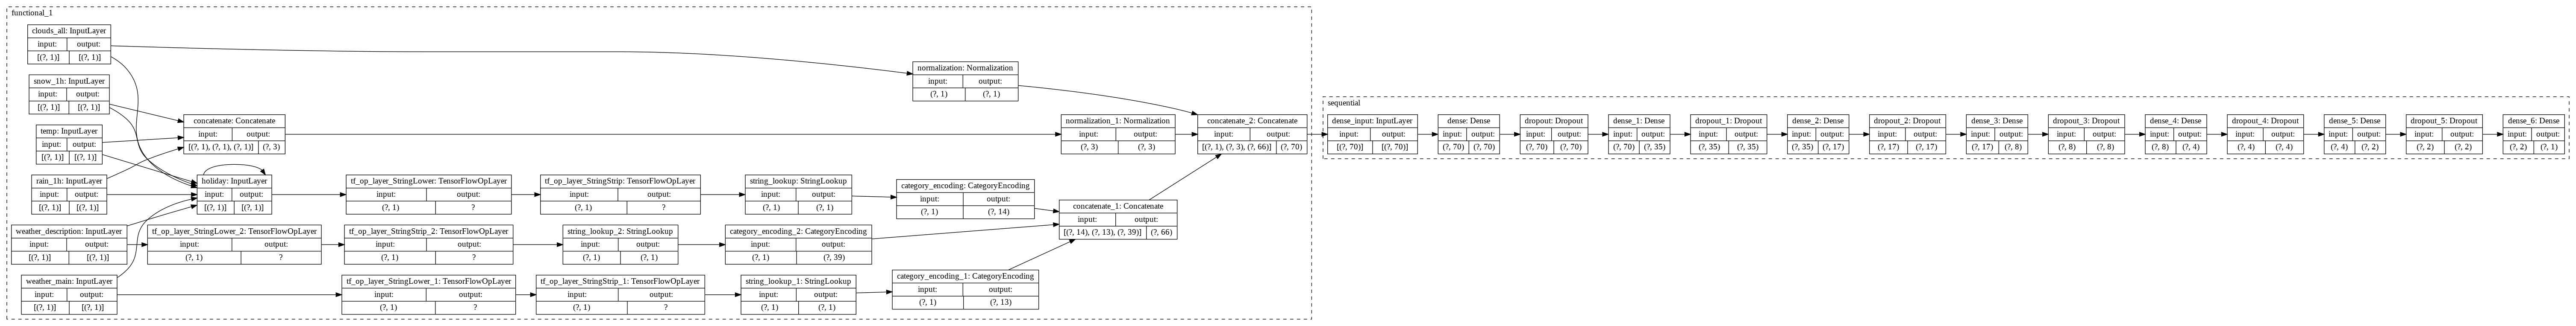

In [ ]:
tf.keras.utils.plot_model(model = model, rankdir="LR", dpi=96, show_shapes=True, expand_nested=True, to_file="model.png")

## Find out training and validation losses with untrained model

In [ ]:
# loss with un-trained model
model.evaluate(train_dataset)

386/386 [==============================] - 1s 3ms/step - loss: 3253.3599


3253.35986328125

In [ ]:
# val_loss with un-trained model
model.evaluate(val_dataset)

97/97 [==============================] - 0s 3ms/step - loss: 3281.2214


3281.221435546875

## Train the model

In [ ]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    callbacks=callbacks,
    epochs=EPOCHS)

Epoch 1/100
    381/Unknown - 2s 4ms/step - loss: 2176.6208WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./metro_models/M.01-1786.59/assets
386/386 [==============================] - 5s 14ms/step - loss: 2176.4272 - val_loss: 1786.5938
Epoch 2/100
386/386 [==============================] - 5s 13ms/step - loss: 2052.6118 - val_loss: 1797.3528
Epoch 3/100
386/386 [==============================] - 5s 13ms/step - loss: 2050.3901 - val_loss: 1809.7979
Epoch 4/100
386/386 [==============================] - 5s 14ms/step - loss: 2029.1384 -

## Find out training and validation losses with trained model

In [ ]:
# loss with trained model
model.evaluate(train_dataset)

386/386 [==============================] - 1s 3ms/step - loss: 1838.2587


1838.2586669921875

In [ ]:
# val_loss with trained model
model.evaluate(val_dataset)

97/97 [==============================] - 0s 3ms/step - loss: 1810.9725


1810.9725341796875

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

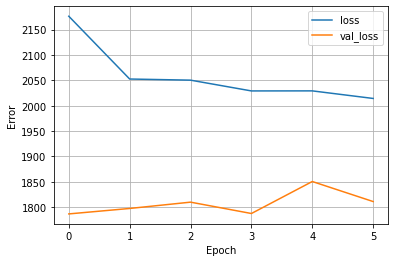

In [ ]:
plot_loss(history)

In [ ]:
def plot_acc(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)

In [ ]:
if TASK == "c":
    plot_acc(history)

## Test the model on some dummy data

In [ ]:
# model.predict({
#     "sex" : np.array(["male"]),
#     "age" : np.array([22.0]),
#     "n_siblings_spouses" : np.array([1]),
#     "parch" : np.array([0]),
#     "fare" : np.array([7.25]),
#     "class" : np.array(["Third"]),
#     "deck" : np.array(["unknown"]),
#     "embark_town" : np.array(["Southampton"]),
#     "alone" : np.array(["n"]),
# })

In [ ]:
# reloaded = tf.keras.models.load_model("models/titanic_model.24-1610.52")

In [ ]:
# reloaded.evaluate(train_dataset)

In [ ]:
# reloaded.evaluate(val_dataset)